In [16]:
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from pathlib import Path
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [26]:
base_path = Path('../../runs/segment/tree_segmentation/yolo_seg_training')
model_path = f'{base_path}/weights/best.pt'
model = YOLO(model_path)

___
#### Вывод метрик на val сете

In [27]:
val_results = model.val(data='../dataset/data.yaml', split='val')
print(val_results)

Ultralytics 8.4.14  Python-3.14.3 torch-2.10.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
YOLO26m-seg summary (fused): 149 layers, 23,509,010 parameters, 0 gradients, 121.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 4545.2185.4 MB/s, size: 2905.3 KB)
val: Scanning D:\fqw\src\dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 83.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s0.2s
                   all        200        597      0.983       0.98      0.988      0.859      0.983       0.98      0.988      0.837
                  tree        198        198      0.979       0.99      0.991      0.857      0.979       0.99      0.991      0.834
                  road        199        399      0.987       0.97      0.985      0.861      0.987       0.97      0.986       0.84
Speed: 0.6ms prepro

In [11]:
metrics = model.metrics

print(f'mAP50-95: {metrics.seg.map:.4f}')
print(f'mAP50: {metrics.seg.map50:.4f}')
print(f'mAP75: {metrics.seg.map75:.4f}')

mAP50-95: 0.8370
mAP50: 0.9885
mAP75: 0.9582


In [12]:
class_names = ['tree', 'road']
for i, name in enumerate(class_names):
    print(f'\n{name}:')
    print(f'  precision: {metrics.seg.p[i]:.4f}')
    print(f'  recall: {metrics.seg.r[i]:.4f}')
    print(f'  mAP50: {metrics.seg.ap50[i]:.4f}')
    print(f'  mAP50-95: {metrics.seg.ap[i]:.4f}')


tree:
  precision: 0.9786
  recall: 0.9899
  mAP50: 0.9907
  mAP50-95: 0.8337

road:
  precision: 0.9872
  recall: 0.9701
  mAP50: 0.9863
  mAP50-95: 0.8403


___
#### Графики метрик (`precision curve`, `recall curve`, `f1 curve`, `pr curve`)

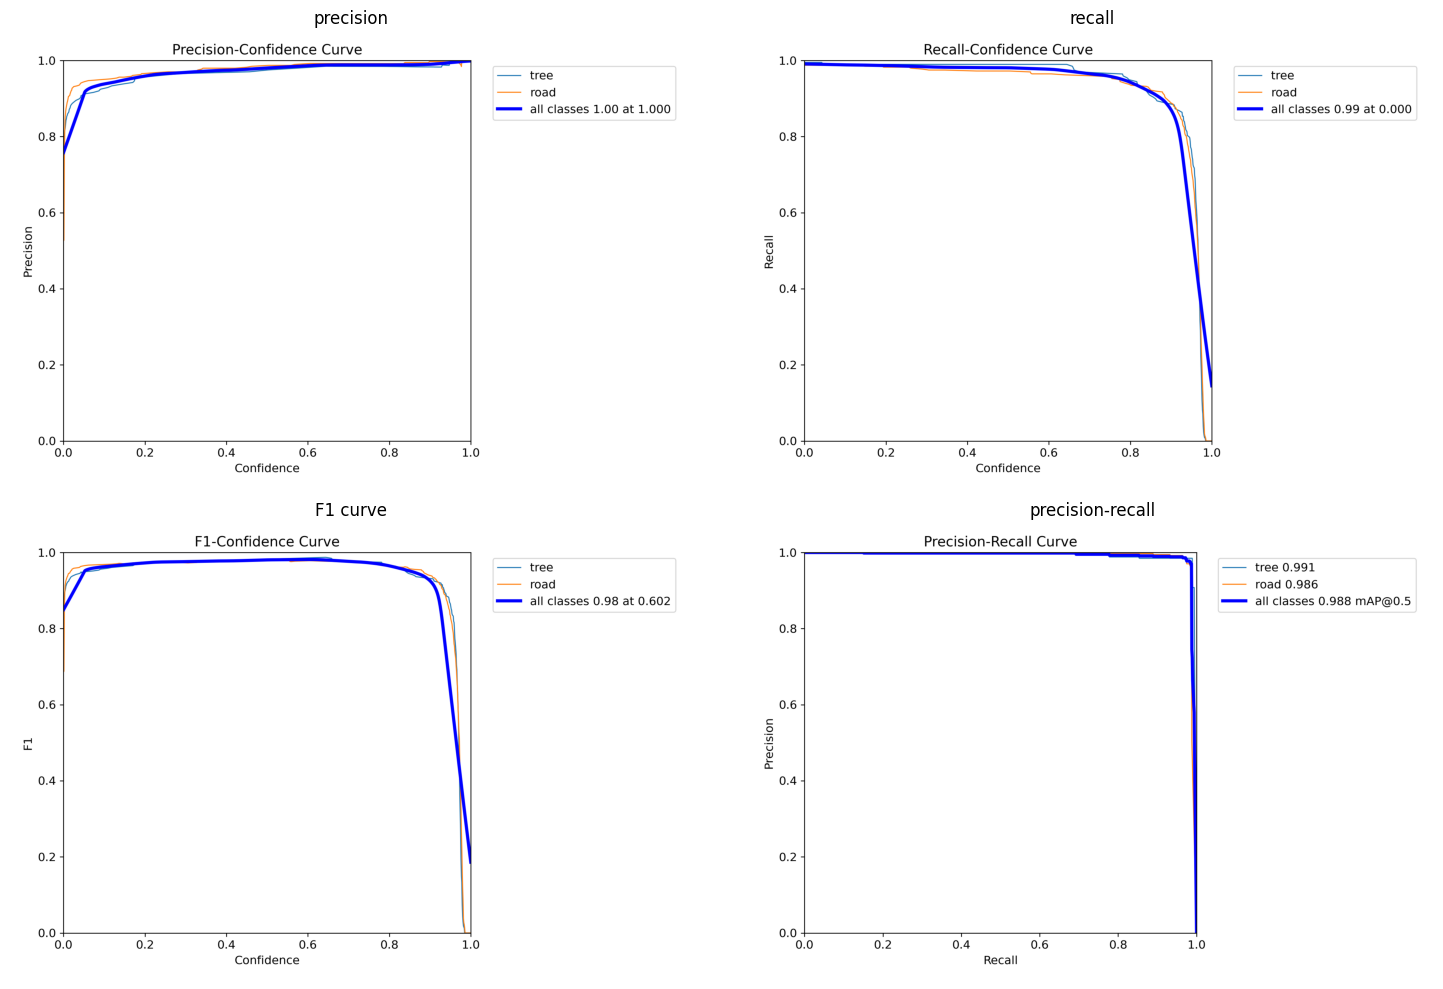

In [30]:
%matplotlib inline

metrics_to_plot = [
    ('MaskP_curve.png', 'precision'),
    ('MaskR_curve.png', 'recall'),
    ('MaskF1_curve.png', 'F1 curve'),
    ('MaskPR_curve.png', 'precision-recall')
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for ax, (metric_file, title) in zip(axes.flat, metrics_to_plot):
    img_path = base_path / metric_file

    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

___
#### Результаты обучения

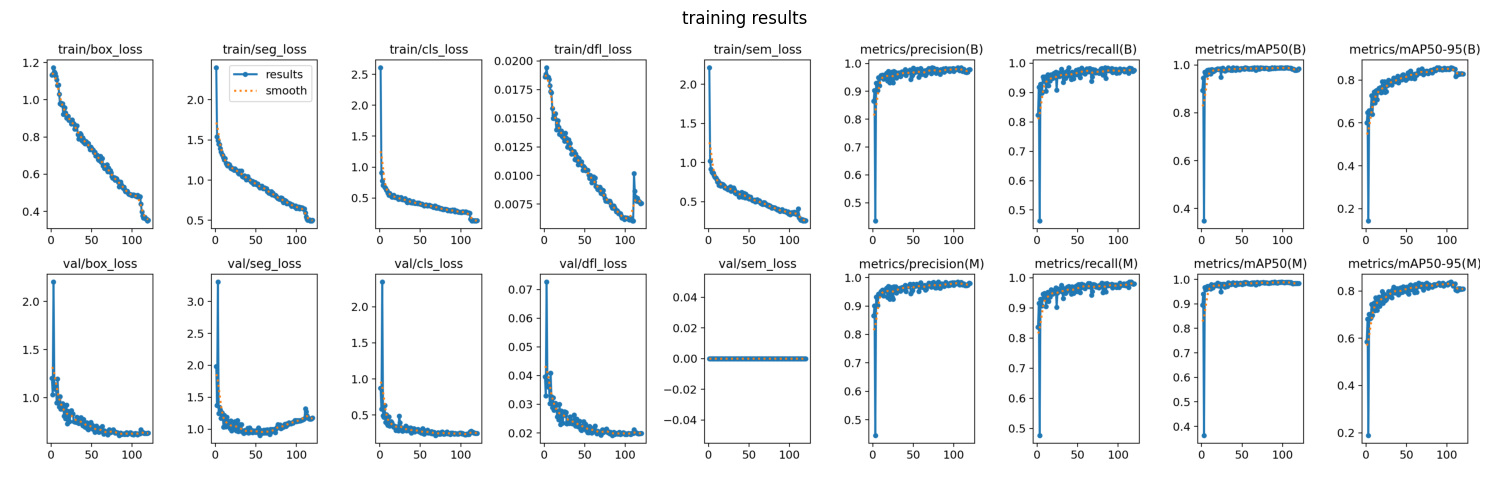

In [41]:
%matplotlib inline

training_results_file = 'results.png'
training_results_title = 'training results'
img_path = base_path / training_results_file

img = mpimg.imread(img_path)
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.title(training_results_title)
plt.axis('off')

plt.tight_layout()
plt.show()

___
#### Матрица классификации

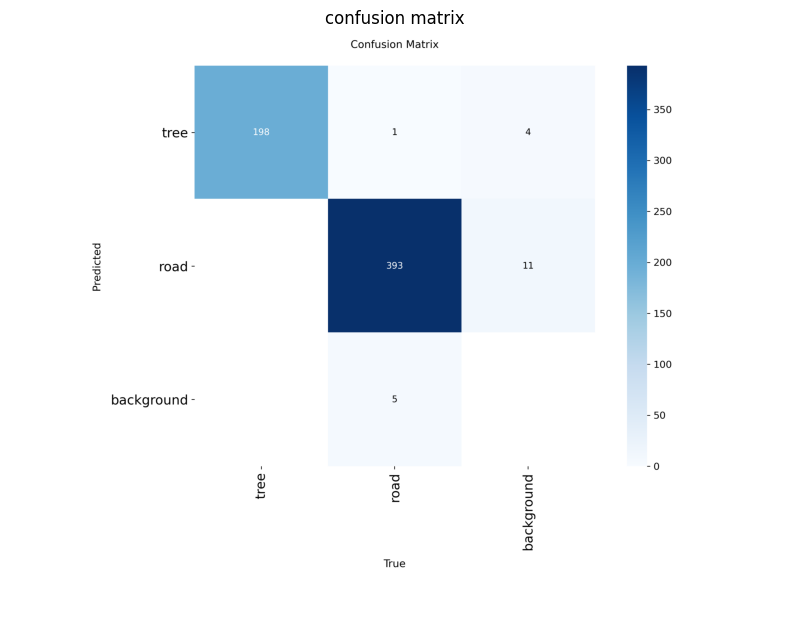

In [43]:
%matplotlib inline

confusion_matrix_file = 'confusion_matrix.png'
confusion_matrix_title = 'confusion matrix'
img_path = base_path / confusion_matrix_file

img = mpimg.imread(img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(confusion_matrix_title)
plt.axis('off')
plt.tight_layout()
plt.show()

___
#### Инференс наглядно


0: 384x640 1 tree, 2 roads, 285.7ms
Speed: 1.9ms preprocess, 285.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


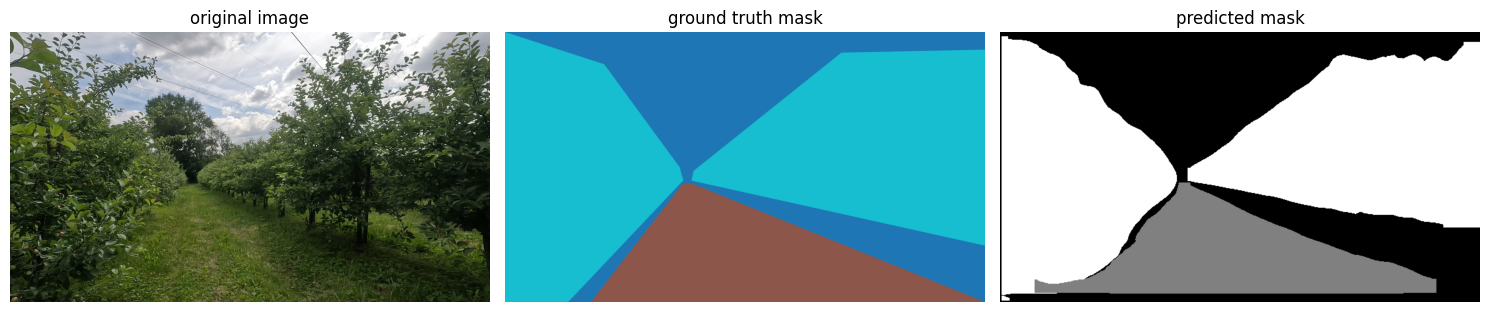

In [60]:
%matplotlib inline

def visualize_predictions(model, image_path, mask_path, class_names=['tree', 'road']):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = model(img, conf=0.5)[0]

    pred_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    if results.masks is not None:
        masks = results.masks.data.cpu().numpy()
        
        for i in range(masks.shape[0]):
            mask = masks[i]
            if mask.shape != (img.shape[0], img.shape[1]):
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
            
            class_id = int(results.boxes.cls[i])
            pred_mask[mask > 0.5] = class_id + 1

    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('original image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap='tab10', vmin=0, vmax=2)
    plt.title('ground truth mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=2)
    plt.title('predicted mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

val_images = list(Path('../dataset/val/images').glob('*.jpg'))
sample_idx = random.sample(range(len(val_images)), 1)[0]

img_path = val_images[sample_idx]
mask_name = val_images[sample_idx].stem + '.png'
mask_path = Path('../masks') / mask_name

visualize_predictions(model, img_path, mask_path)
plt.show()